# Check variance of resulting SMICA powerspectrum and compare effect of masks and datasets
## Header

In [64]:
%%capture
import numpy as np
import smica
import os
import matplotlib.gridspec as gridspec
import json

import warnings
warnings.filterwarnings('ignore')

import copy
from astropy.io import fits
import matplotlib.pyplot as plt
import healpy as hp

from component_separation.io import IO
import component_separation.powerspectrum as pospec
import component_separation.map as mp
import component_separation.transformer as trsf

from component_separation.cs_util import Config
from component_separation.cs_util import Smica_bins as const
from component_separation.cs_util import Helperfunctions as hpf
from component_separation.cs_util import Filename_gen_SMICA as fns_gen
from component_separation.cs_util import Filename_gen as fn_gen

csu = Config()
io = IO(csu)
fn = fn_gen(csu)
fns = fns_gen(csu)
tebdict = {0:'I', 1:'Q', 2:'U'}

lmax=csu.lmax
nside_out = csu.nside_out
bins = csu.bins
detector = csu.FREQ_f
specfilter = csu.specfilter
freqfilter = csu.FREQFILTER
freqdset = csu.freqdset
lmaxbins = int(bins[-1][1])
colors=csu.CB_color_cycle
bcorr = [
    hp.gauss_beam(val, lmax, pol = True)[:,1]
    for val in [
        0.00930842,
        0.00785398,
        0.00378155,
        0.002807071,
        0.002106031,
        0.00145444,
        0.00140499,
        ]
    ]
beam5 = hp.gauss_beam(0.001454441043324941835, lmax, pol = True)[:,1]
spectrum_truth = io.load_truthspectrum()
spectrum_truth.shape

In [4]:
def get_mask(freqdset, mskset, spectrum_type):
    csu = Config(freqdset=freqdset, mskset=mskset, spectrum_type=spectrum_type, verbose=False)
    fn = fn_gen(csu)
    fns = fns_gen(csu)
    io = IO(csu)
    apo = csu.spectrum_type == 'pseudo'
    tmask_fn = fn.get_mask('T', apodized=apo)
    pmask_fn = fn.get_mask('P', apodized=apo)
    tmask_sg = io.load_mask(tmask_fn, stack=True)
    pmask_sg = io.load_mask(pmask_fn, stack=True)

    tmask, pmask = dict(), dict()
    for FREQ in csu.FREQ:
        if FREQ not in csu.FREQFILTER:
            tmask[FREQ] = tmask_sg
            pmask[FREQ] = pmask_sg
    return tmask, pmask
import itertools
mask = dict()
for mskset, spectrum_type in itertools.product(['lens', 'smica'], ['pseudo', 'JC']):
    tmask, pmask = get_mask(freqdset=freqdset, mskset=mskset, spectrum_type=spectrum_type)
    if mskset in mask:
        if spectrum_type in mask[mskset]:
            mask[mskset].update({
                'T': tmask,
                 'P': pmask,
            })
        else:
            mask[mskset].update({
                spectrum_type:{
                    'T': tmask,
                     'P': pmask,
            }})
    else:
        mask.update({
            mskset:{
                spectrum_type:{
                    'T': tmask,
                     'P': pmask,
            }}})

In [28]:
smica_params = dict({'cov': None, "cov4D": None, "CMB": None, "gal_mm": None, "w": None})
smica_params = dict()
prod = [['NPIPE', 'DX12'], ['lens', 'smica'], ['pseudo', 'JC']]
dhelper = dict({'cov': None, "cov4D": None, "CMB": None, "gal_mm": None, "w": None})
lmax_loc = 4000
clmin = dict()
simid=-1
W = dict()
beamf = dict()
for freqdset, mskset, spectrum_type in itertools.product(*prod):
    if freqdset in smica_params:
        if mskset in smica_params[freqdset]:
                smica_params[freqdset][mskset].update({spectrum_type: dhelper})
                clmin[freqdset][mskset].update({spectrum_type: None})
        else:
            smica_params[freqdset].update({mskset:{spectrum_type: dhelper}})
            clmin[freqdset].update({mskset:{spectrum_type: None}})
    else:
        smica_params.update({freqdset: {mskset:{spectrum_type: dhelper}}})
        clmin.update({freqdset: {mskset:{spectrum_type: None}}})
    if freqdset in W:
        if mskset in W[freqdset]:
                W[freqdset][mskset].update({spectrum_type: None})
        else:
            W[freqdset].update({mskset:{spectrum_type: None}})
    else:
        W.update({freqdset: {mskset:{spectrum_type: None}}})
        
for freqdset, mskset, spectrum_type in itertools.product(*prod):
    csu = Config(freqdset=freqdset, mskset=mskset, spectrum_type=spectrum_type, verbose=False)
    fn = fn_gen(csu)
    fns = fns_gen(csu)
    bins = csu.bins
    W_smica = io.load_data(fns.get_misc('w', simid=simid))
    W_mv = io.load_data(fn.get_misc('w', simid=simid))
    
    if freqdset not in beamf:
        beamf[freqdset] = io.load_beamf(csu.freqcomb, csu.lmax, csu.freqdatsplit)
    if W_smica is not None and W_mv is not None:
        W_total = hpf.interp_smica_mv_weights(W_smica, W_mv, bins, 4001)
        W[freqdset][mskset][spectrum_type] = W_total
        W[freqdset][mskset][spectrum_type][:,:,0:2] = 0.0
    clmin[freqdset][mskset][spectrum_type] = io.load_data(fns.get_spectrum("T", "combined", simid=-1))
    for k, v in smica_params[freqdset][mskset][spectrum_type].items():
        smica_params[freqdset][mskset][spectrum_type][k] = io.load_data(fns.get_misc(k))

loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_w_SMICA_highell_bins_pseudo.npy
no existing data at /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/w_pseudo.npy
no existing data at /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/ClT_combined_SMICA_highell_bins_2048_4000_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_cov_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_cov4D_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_CMB_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_gal_mm_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_w_SMICA_highell_bins_pseudo.npy
loaded /global/cscratch1/sd/sebibel/compsep/planck/NPIPE/lensmask/smica_w_SMICA_highell_bins_JC.npy
loaded /global/cscratch1/sd/sebibel/com

NPIPE lens JC (9, 4001)
DX12 smica JC (9, 4001)


(1e-16, 3e-15)

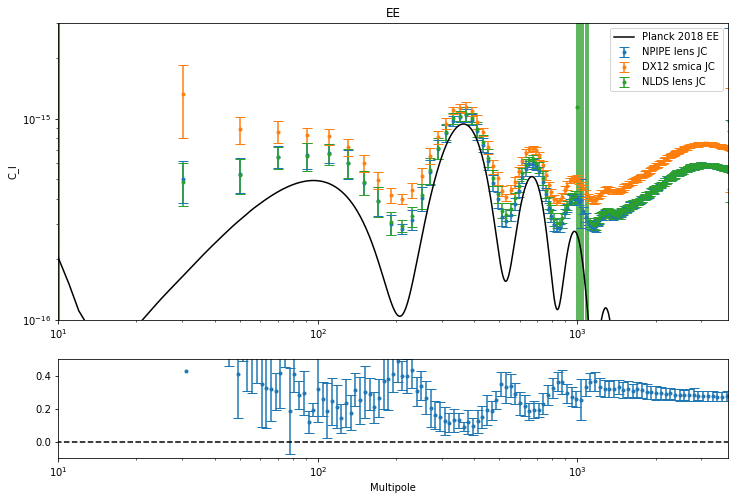

In [109]:
%matplotlib inline
EBidx = 0
nbins = 200
fig = plt.figure(figsize=(12,8))
gs = gridspec.GridSpec(2, 1, height_ratios=[3,1])
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

for freqdset, mskset, spectrum_type in itertools.product(*prod):
    if freqdset in clmin:
        if mskset in clmin[freqdset]:
            if spectrum_type in clmin[freqdset][mskset]:
                if clmin[freqdset][mskset][spectrum_type] is not None:
                    if freqdset == 'DX12' and  mskset == 'lens':
                        pass
                    else:
                        if clmin[freqdset][mskset][spectrum_type][EBidx].shape[0] == 9:
                            print(freqdset, mskset, spectrum_type, clmin[freqdset][mskset][spectrum_type][EBidx].shape)
                            mean, err, _ = hpf.std_dev_binned(clmin[freqdset][mskset][spectrum_type][EBidx][1], binwidth=nbins, lmax=4001, log=False)  
                            ax0.errorbar((_[1:]+_[:-1])/2, mean, yerr=err, label='{} {} {}'.format(freqdset,mskset, spectrum_type), fmt= '.', capsize=5)
                            
                else:
                    pass
            else:
                pass
mean, err, _ = hpf.std_dev_binned(ClTcombNLDS[0,1], binwidth=nbins, lmax=4001, log=False)
ax0.errorbar((_[1:]+_[:-1])/2, mean, yerr=err, label='{} {} {}'.format('NLDS','lens', 'JC'), fmt= '.', capsize=5)
ll = np.arange(0,4000,1)
ax0.plot(spectrum_truth['Planck-{}'.format('EE')].to_numpy()[:lmax_loc]*1e-12/(ll*(ll+1)/(2*np.pi)), label= 'Planck 2018 EE', color='black')
meanNLNL, errNLNL, _ = hpf.std_dev_binned(clmin['NPIPE']['lens']['JC'][0][1], binwidth=nbins, lmax=4001, log=True)
meanDSDS, errDSDS, _ = hpf.std_dev_binned(clmin['DX12']['smica']['JC'][0][1], binwidth=nbins, lmax=4001, log=True)  
meanR, errR, _ = hpf.std_dev_binned(clmin['DX12']['smica']['JC'][0][1]/clmin['NPIPE']['lens']['JC'][0][1]-1, binwidth=nbins, lmax=4001, log=True)
ax1.errorbar((_[1:]+_[:-1])/2, meanR, yerr=errR, fmt= '.', capsize=5)
ax1.hlines(0, 0, 4000, ls='--', color='black')
ax1.set_ylim((-0.1,0.5))

ax0.legend()
ax0.set_yscale('log')
ax0.set_ylabel('C_l')
ax0.set_xscale('log')
ax1.set_xscale('log')
ax0.set_xlim((10,3800))
ax1.set_xlim((10,3800))
if EBidx == 0:
    ax0.set_title('EE')
else:
    ax0.set_title('BB')
ax1.set_xlabel('Multipole')
ax0.set_ylim((1e-16,3e-15))

# MV spectrum/map for NPIPE lens with DX12 smica weights

In [7]:
maps = dict()
for freqdset in ['NPIPE', 'DX12']:
    maps[freqdset] = dict()
    csu = Config(freqdset=freqdset, verbose=False)
    fn = fn_gen(csu)
    for FREQ in csu.FREQ:
        if FREQ not in csu.FREQFILTER:
            inpath_map_pla_name = fn.get_d(FREQ, "T", simid=simid)
            print("inpath_map_pla_name: {}".format(inpath_map_pla_name))
            nside_out = csu.nside_out[0] if int(FREQ)<100 else csu.nside_out[1]
            maps[freqdset][FREQ] = io.load_d(inpath_map_pla_name, field=(0,1,2), nside_out=nside_out)
    maps[freqdset] = mp.process_all(maps[freqdset])

inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_030_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_044_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_070_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_100_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_143_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_217_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2020/npipe/npipe6v20/npipe6v20_353_map.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/LFI_SkyMap_030_1024_R3.00_full.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/LFI_SkyMap_044_1024_R3.00_full.fits
inpath_map_pla_name: /global/cfs/cdirs/cmb/data/planck2018/pr3/frequencymaps/LFI_SkyMap_

# Choice No1 - NLDS - MV NPIPE lens with DX12 smica weights

In [114]:
M_spectrum_type_c = 'JC'
M_maskset_c = 'lens'
M_freqdset_c = 'NPIPE'
M_mask_c = mask[M_maskset_c][M_spectrum_type_c]
maps_c = maps[M_freqdset_c]
beam = beamf[M_freqdset_c]

W_freqdset_c = 'DX12'
W_maskset_c = 'smica'
W_spectrum_type_c = 'JC'

apo = M_spectrum_type_c == 'pseudo'

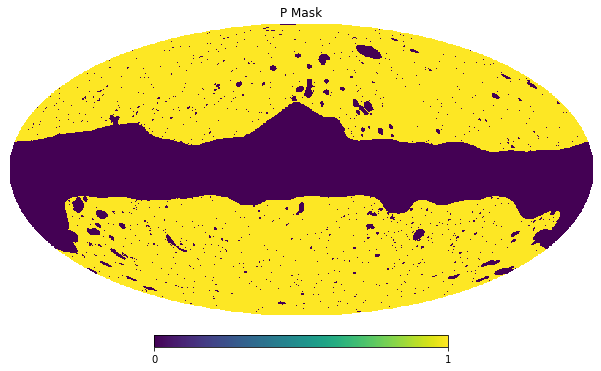

In [116]:
hp.mollview(M_mask_c['T']['030'], title='P Mask')

## Take existing..

In [ ]:
alm = io.load_data('/global/cscratch1/sd/sebibel/compsep/misc/alm_NL.npy')
almE = alm[:,1,:]
almB = alm[:,2,:]

In [ ]:
combalm = ioc.load_data("/global/cscratch1/sd/sebibel/compsep/misc/alm_NLDS.npy")
combalmE = combalm[1]
combalmB = combalm[2]

In [ ]:
MV_map_NLDS = io.load_data("/global/cscratch1/sd/sebibel/compsep/misc/alm_NLDS")

## ..or recalculate

In [17]:
nalm = int((lmax_loc+1)*(lmax_loc+2)/2) 
alm = np.zeros(shape=(len(csu.FREQ_f),3,nalm), dtype=np.complex128)
print('Calculating alms')
for itf, freq in enumerate(csu.FREQ_f):
    print('freq: ', freq)
    ns = csu.nside_out[0] if int(freq) < 100 else csu.nside_out[1]
    if apo:
        alm[itf][1:] = hp.map2alm(
            np.array([n*hp.ud_grade(M_mask_c['P'][freq], nside_out=ns)
                      for n in maps_c[freq]]), lmax_loc)[1:]
    else:
        alm[itf][1:] = trsf.map2alm_spin(
            maps_c[freq],
            hp.ud_grade(M_mask_c['P'][freq],
                        nside_out=ns), 2, lmax_loc)

Calculating alms
freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [22]:
combalmE = np.zeros((nalm), dtype=np.complex128)
combalmB = np.zeros((nalm), dtype=np.complex128)
beam_e = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,1]
beam_b = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,2]
print('Calculating combination {}-{} data with {}-{} weights'.format(M_freqdset_c, M_maskset_c, W_freqdset_c, W_maskset_c))
for itf, det in enumerate(csu.FREQ): #weights do not depend on FREQFILTER, but almE/B do
    if det in csu.FREQ_f:
        print('freq: ', det)
        ns = csu.nside_out[0] if int(det) < 100 else csu.nside_out[1]
        # combalmT += hp.almxfl(almT[name], np.squeeze(W[0,m,:]))
        combalmE += np.nan_to_num(hp.almxfl(
            alm[itf][1], W[W_freqdset_c][W_maskset_c][W_spectrum_type_c][1,itf,:lmax_loc]*hp.gauss_beam(np.radians(5/60), lmax_loc-1, pol = True)[:,1]/np.nan_to_num(beam[1,itf,itf,:lmax_loc])))
        combalmB += np.nan_to_num(hp.almxfl(
            alm[itf][2], W[W_freqdset_c][W_maskset_c][W_spectrum_type_c][2,itf,:lmax_loc]*hp.gauss_beam(np.radians(5/60), lmax_loc-1, pol = True)[:,2]/np.nan_to_num(beam[2,itf,itf,:lmax_loc])))
        # combalmB = hp.almxfl(combalmB, 1/hp.pixwin(ns, pol=True)[1][:lmax_loc])

Calculating combination NPIPE-lens data with DX12-smica weights
freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [23]:
mapT_combined = hp.alm2map([np.zeros_like(combalmE), combalmE, combalmB], csu.nside_out[1])
ClTcombNLDS = trsf.map2cls({'combined':mapT_combined}, {'combined':M_mask_c['P']['030']}, {'combined':M_mask_c['P']['030']}, M_spectrum_type_c, lmax_loc, freqcomb=['combined-combined'], lmax_mask=csu.lmax_mask)

## Look at the result

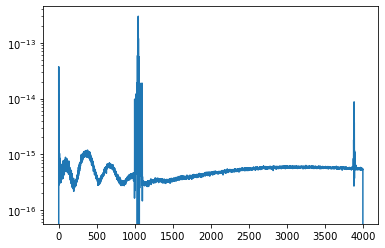

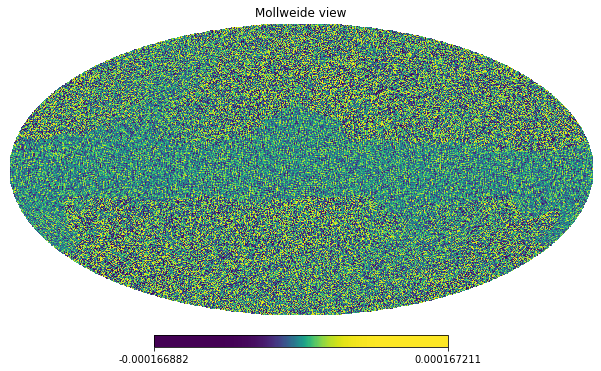

In [24]:
plt.plot(ClTcombNLDS[0,1])
plt.yscale('log')
hp.mollview(mapT_combined[1], norm='hist')

## Store the data

In [25]:
io.save_data(alm, '/global/cscratch1/sd/sebibel/compsep/misc/alm_NL.npy')

io.py: Data saved to /global/cscratch1/sd/sebibel/compsep/misc/alm_NL.npy


In [26]:
comb = np.array([np.zeros_like(combalmE), combalmE, combalmB])
io.save_data(comb, "/global/cscratch1/sd/sebibel/compsep/misc/alm_NLDS.npy")

io.py: Data saved to /global/cscratch1/sd/sebibel/compsep/misc/alm_NLDS.npy


# Choice No2 - DSDS - DX12 smica with DX12 smica weights

In [41]:
M_spectrum_type_c = 'JC'
M_freqdset_c = 'DX12'
M_maskset_c = 'smica'

maps_c = maps[M_freqdset_c]
apo = M_spectrum_type_c == 'pseudo'
M_mask_c = mask[M_maskset_c][M_spectrum_type_c]
beam = beamf[M_freqdset_c]

W_freqdset_c = 'DX12'
W_maskset_c = 'smica'
W_spectrum_type_c = 'JC'

ClTcombNLNL = clmin['NPIPE']['lens']['JC'][0]## Take existing..

In [31]:
ClTcombDSDS = clmin['DX12']['smica']['JC'][0]

In [ ]:
almE = io.load_data('/global/cscratch1/sd/sebibel/misc/almE_Npipe_lens.npy')
almB = io.load_data('/global/cscratch1/sd/sebibel/misc/almB_Npipe_lens.npy')

combalmE_NPlensDXsmica = ioc.load_data("/global/cscratch1/sd/sebibel/misc/combalmE_Npipe_lens_DX12smicaweights.npy")
combalmB_NPlensDXsmica = ioc.load_data("/global/cscratch1/sd/sebibel/misc/combalmB_Npipe_lens_DX12smicaweights.npy")

MV_map_NPlensDXsmica = io.load_data("/global/cscratch1/sd/sebibel/misc/MVmap_Npipe_lens_DX12smicaweights.npy")

## ..or recalculate

In [70]:
nalm = int((lmax_loc+1)*(lmax_loc+2)/2) 
alm = np.zeros(shape=(len(csu.FREQ_f),3,nalm))
print('Calculating alms')
for itf, freq in enumerate(csu.FREQ_f):
    print('freq: ', freq)
    ns = csu.nside_out[0] if int(freq) < 100 else csu.nside_out[1]
    if apo:
        alm[itf][1:] = hp.map2alm(np.array([n*hp.ud_grade(M_mask_c['P'][freq], nside_out=ns) for n in maps_c[freq]]), lmax_loc)[1:]
    else:
        alm[itf][1:] = trsf.map2alm_spin(maps_c[freq], hp.ud_grade(M_mask_c['P'][freq], nside_out=ns), 2, lmax_loc)

Calculating alms
freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [71]:
combalmE = np.zeros((nalm), dtype=np.complex128)
combalmB = np.zeros((nalm), dtype=np.complex128)
beam_e = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,1]
beam_b = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,2]
print('Calculating combination {}-{} data with {}-{} weights'.format(M_freqdset_c, M_maskset_c, W_freqdset_c, W_maskset_c))
for itf, det in enumerate(csu.FREQ): #weights do not depend on FREQFILTER, but almE/B do
    if det in csu.FREQ_f:
        print('freq: ', det)
        ns = csu.nside_out[0] if int(det) < 100 else csu.nside_out[1]
        # combalmT += hp.almxfl(almT[name], np.squeeze(W[0,m,:]))
        combalmE += hp.almxfl(
            hp.almxfl(
                hp.almxfl(
                    alm[itf][1], np.nan_to_num(1/beam[1,itf,itf,:lmax_loc])),
                beam_e[:lmax_loc]),
            np.squeeze(W[W_freqdset_c][W_maskset_c][W_spectrum_type_c][1,itf,:lmax_loc]))
        # combalmE = hp.almxfl(combalmE, 1/hp.pixwin(ns, pol=True)[0][:lmax_loc])
        combalmB += hp.almxfl(
            hp.almxfl(
                hp.almxfl(
                    alm[itf][2], np.nan_to_num(1/beam[2,itf,itf,:lmax_loc])),
                    beam_b[:lmax_loc]),
            np.squeeze(W[W_freqdset_c][W_maskset_c][spectrum_type_c][2,itf,:lmax_loc]))
        # combalmB = hp.almxfl(combalmB, 1/hp.pixwin(ns, pol=True)[1][:lmax_loc])

Calculating combination DX12-smica data with DX12-smica weights
freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


In [72]:
mapT_combined = hp.alm2map([np.zeros_like(combalmE), combalmE, combalmB], csu.nside_out[1])
ClTcombDSDS = trsf.map2cls({'combined':mapT_combined}, {'combined':M_mask_c['P']['030']}, {'combined':M_mask_c['P']['030']}, M_spectrum_type_c, lmax_loc, freqcomb=['combined-combined'], lmax_mask=csu.lmax_mask)

## Look at the result

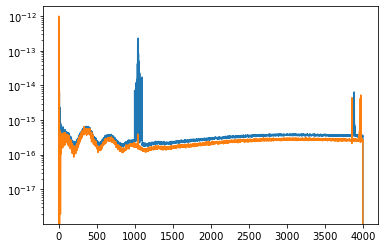

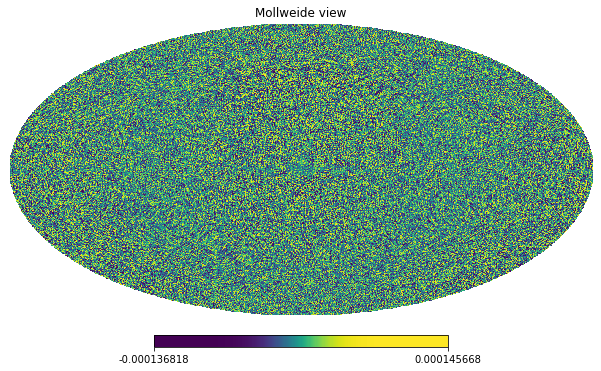

In [112]:
plt.plot(ClTcombDSDS[0,1])
plt.yscale('log')
plt.show()
hp.mollview(mapT_combined[1], norm='hist')

## Store the data

In [96]:
io.save_data(alm, '/global/cscratch1/sd/sebibel/compsep/misc/alm_DS.npy')
comb = np.array([np.zeros_like(combalmE), combalmE, combalmB])
io.save_data(comb, "/global/cscratch1/sd/sebibel/compsep/misc/alm_DSDS.npy")

io.py: Data saved to /global/cscratch1/sd/sebibel/compsep/misc/alm_DS.npy
io.py: Data saved to /global/cscratch1/sd/sebibel/compsep/misc/alm_DSDS.npy


# Choice No3 - NLNL - NPIPE lens data with NPIPE lens weights

## Take existing..

In [30]:
ClTcombNLNL = clmin['NPIPE']['lens']['JC'][0]

## ..or recalculate

In [141]:
M_spectrum_type_c = 'JC'
M_freqdset_c = 'NPIPE'
M_maskset_c = 'lens'

maps_c = maps[M_freqdset_c]
apo = M_spectrum_type_c == 'pseudo'
M_mask_c = mask[M_maskset_c][M_spectrum_type_c]
beam = beamf[M_freqdset_c]

W_spectrum_type_c = 'JC'
W_freqdset_c = 'NPIPE'
W_maskset_c = 'lens'

nalm = int((lmax_loc+1)*(lmax_loc+2)/2) 
alm = np.zeros(shape=(len(csu.FREQ_f),3,nalm))
print('Calculating alms')
for itf, freq in enumerate(csu.FREQ_f):
    print('freq: ', freq)
    ns = csu.nside_out[0] if int(freq) < 100 else csu.nside_out[1]
    if apo:
        alm[itf][1:] = hp.map2alm(np.array([n*hp.ud_grade(M_mask_c['P'][freq], nside_out=ns) for n in maps_c[freq]]), lmax_loc)[1:]
    else:
        alm[itf][1:] = trsf.map2alm_spin(maps_c[freq], hp.ud_grade(M_mask_c['P'][freq], nside_out=ns), 2, lmax_loc)
        
combalmE = np.zeros((nalm), dtype=np.complex128)
combalmB = np.zeros((nalm), dtype=np.complex128)
beam_e = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,1]
beam_b = hp.gauss_beam(np.radians(5/60), 4100, pol = True)[:,2]
print('Calculating combination {}-{} data with {}-{} weights'.format(M_freqdset_c, M_maskset_c, W_freqdset_c, W_maskset_c))
for itf, det in enumerate(csu.FREQ): #weights do not depend on FREQFILTER, but almE/B do
    if det in csu.FREQ_f:
        print('freq: ', det)
        ns = csu.nside_out[0] if int(det) < 100 else csu.nside_out[1]
        # combalmT += hp.almxfl(almT[name], np.squeeze(W[0,m,:]))
        combalmE += hp.almxfl(
            hp.almxfl(
                hp.almxfl(
                    alm[itf][1], np.nan_to_num(1/beam[1,itf,itf,:lmax_loc])),
                beam_e[:lmax_loc]),
            np.squeeze(W[W_freqdset_c][W_maskset_c][W_spectrum_type_c][1,itf,:lmax_loc]))
        # combalmE = hp.almxfl(combalmE, 1/hp.pixwin(ns, pol=True)[0][:lmax_loc])
        combalmB += hp.almxfl(
            hp.almxfl(
                hp.almxfl(
                    alm[itf][2], np.nan_to_num(1/beam[2,itf,itf,:lmax_loc])),
                    beam_b[:lmax_loc]),
            np.squeeze(W[W_freqdset_c][W_maskset_c][spectrum_type_c][2,itf,:lmax_loc]))
        # combalmB = hp.almxfl(combalmB, 1/hp.pixwin(ns, pol=True)[1][:lmax_loc])
        
mapT_combined = hp.alm2map([np.zeros_like(combalmE), combalmE, combalmB], csu.nside_out[1])
ClTcombNLNL = trsf.map2cls({'combined':mapT_combined}, {'combined':M_mask_c['P']['030']}, {'combined':M_mask_c['P']['030']}, M_spectrum_type_c, lmax_loc, freqcomb=['combined-combined'], lmax_mask=csu.lmax_mask)

Calculating alms
freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353
Calculating combination NPIPE-lens data with NPIPE-lens weights
freq:  030
freq:  044
freq:  070
freq:  100
freq:  143
freq:  217
freq:  353


## Choice 4

# Variance

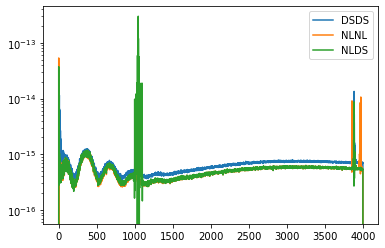

In [38]:
plt.plot(ClTcombDSDS[1], label= 'DSDS')
plt.plot(ClTcombNLNL[1], label= 'NLNL')
plt.plot(ClTcombNLDS[0,1], label= 'NLDS')
plt.legend()
plt.yscale('log')
# plt.ylim((1e-16,1e-15))

In [99]:
ll = np.arange(0,4001,1)
TEB = 1
avar_NLDS = 2 * ClTcombNLDS[0,EBidx,:] * ClTcombNLDS[0,EBidx,:]/((2*ll+1)*0.67)
avar_DSDS = 2 * ClTcombDSDS[EBidx,:] * ClTcombDSDS[EBidx,:]/((2*ll+1)*0.97)
avar_NLNL = 2 * ClTcombNLNL[EBidx,:] * ClTcombNLNL[EBidx,:]/((2*ll+1)*0.67)
# approx_variance_NPpropag = 2 * propag_smica_C_lmin_sc[EBidx,:] * propag_smica_C_lmin_sc[EBidx,:]/((2*ll+1)*0.67)

(1e-35, 1e-32)

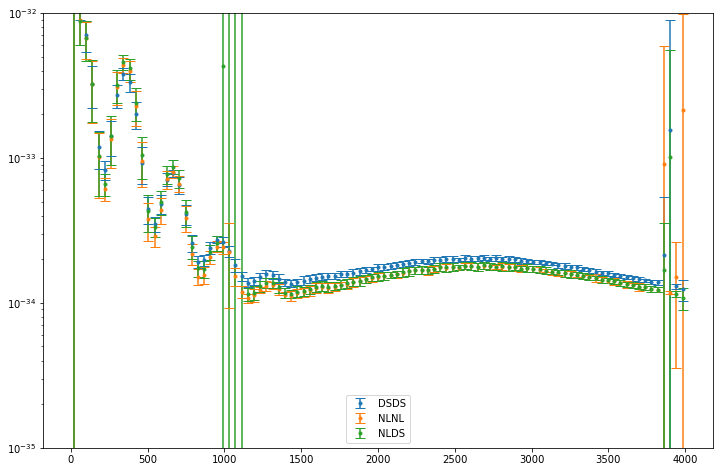

In [100]:
fig = plt.figure(figsize=(12,8))
mean, std, _ = hpf.std_dev_binned(avar_DSDS, lmax=4001, binwidth=100, log=False)
plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=std, fmt='.', capsize=5, label= 'DSDS')

mean, std, _ = hpf.std_dev_binned(avar_NLNL, lmax=4001, binwidth=100, log=False)
plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=std, fmt='.', capsize=5, label= 'NLNL')

mean, std, _ = hpf.std_dev_binned(avar_NLDS, lmax=4001, binwidth=100, log=False)
plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=std, fmt='.', capsize=5, label= 'NLDS')
plt.legend()
plt.yscale('log')
plt.ylim((1e-35,1e-32))

Text(0.5, 1.0, 'Comparing Variance of combined spectra')

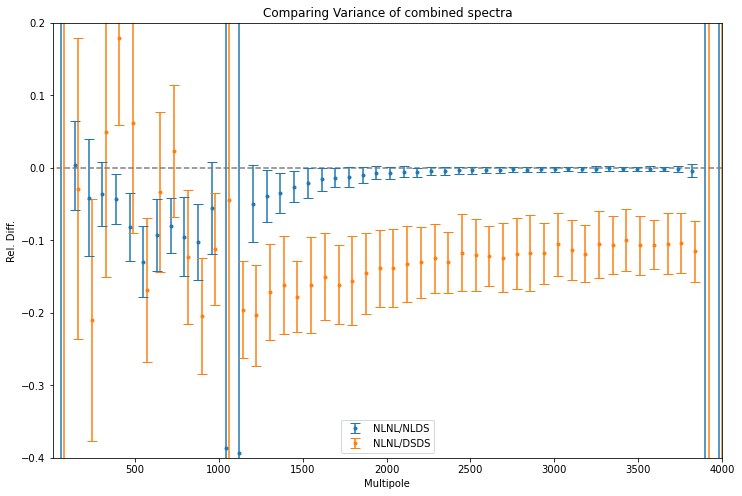

In [110]:
%matplotlib inline
fig = plt.figure(figsize=(12,8))
# mean, std, _ = hpf.std_dev_binned(avar_NLDS/avar_DSDS-1, lmax=4001, binwidth=50, log=False)
# plt.errorbar((_[1:]+_[:-1])/2, mean, yerr=std, fmt='.', capsize=5, label= 'NLDS/DSDS')
mean, std, _ = hpf.std_dev_binned(avar_NLNL/avar_NLDS-1, lmax=4001, binwidth=50, log=False)
plt.errorbar((_[1:]+_[:-1])/2+20, mean, yerr=std, fmt='.', capsize=5, label= 'NLNL/NLDS')
mean, std, _ = hpf.std_dev_binned(avar_NLNL/avar_DSDS-1, lmax=4001, binwidth=50, log=False)
plt.errorbar((_[1:]+_[:-1])/2+40, mean, yerr=std, fmt='.', capsize=5, label= 'NLNL/DSDS')

plt.hlines(0,lmax,0, ls='--', color= 'gray')
plt.ylim((-0.4,0.2))
# plt.yscale('log')
plt.xlim((1e1,4e3))
plt.legend()
plt.xlabel('Multipole')
plt.ylabel('Rel. Diff.')
plt.title('Comparing Variance of combined spectra')
# plt.yscale('log')

# Backup